In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Canny边缘检测算法是一种被广泛使用的边缘检测技术，由John F. Canny在1986年提出。它旨在从图像中提取有用的结构信息，并尽可能准确地标记边缘的位置。Canny算法的目标是满足三个主要标准：低错误率（边缘被正确检测），边缘定位的高精度（检测到的边缘尽可能接近真实边缘），以及对单个边缘的响应最小化（图像中的边缘只被标记一次）。为了达到这些目标，Canny边缘检测算法包括以下几个步骤：

### 1. 噪声降低

由于边缘检测容易受到图像噪声的影响，第一步是使用高斯滤波器平滑图像，以减少图像中的噪声。高斯滤波器是一种低通滤波器，可以移除图像中的高频部分（即噪声），同时保留低频部分（即边缘等重要结构）。


$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$


### 2. 寻找图像梯度的强度和方向

接下来

，使用Sobel算法计算水平和垂直方向上的梯度强度。这一步骤可以揭示图像中亮度变化最显著的区域，即潜在的边缘位置。通过这两个方向的梯度，可以进一步计算出每个像素位置的边缘梯度强度（G）和方向（θ）：

- 梯度强度 $$ G = \sqrt{G_x^2 + G_y^2}$$
- 梯度方向 $$\theta = \arctan\left(\frac{G_y}{G_x}\right)$$



梯度方向被量化到四个主要方向之一（通常是0°, 45°, 90°, 和135°），这样做是为了简化后续的边缘跟踪过程。

### 3. 非极大值抑制

在这一步，算法会沿着梯度方向检查像素，仅保留梯度强度在该方向上局部最大的像素点，而非局部最大的点被认为不是边缘的一部分而被抑制。这一步骤的目的是去除那些模糊和宽敞的边缘，使边缘更加细薄。

### 4. 双阈值算法

为了进一步确定真正的边缘，Canny算法使用了双阈值方法来区分强边缘、弱边缘和非边缘。具体来说，设置两个阈值：高阈值和低阈值。高于高阈值的梯度被认为是强边缘；低于低阈值的梯度被认为是非边缘；而介于两者之间的梯度则被认为是弱边缘。

### 5. 边缘跟踪通过滞后

在最后一步，算法通过滞后技术处理弱边缘。只有当弱边缘与强边缘相连时，这些弱边缘才会被保留；否则，它们会被抑制。这样做可以确保只有真正的边缘被检测到，同时减少了错误检测的可能性。

Canny边缘检测算法因其准确性和鲁棒性而被广泛应用于各种图像处理场景中，尤其是在需要高精度边缘检测的应用中。

##### 高斯濾波 



$$
G(x, y) = \frac{1}{2\pi\sigma^2} e^{-\frac{x^2 + y^2}{2\sigma^2}}
$$
1.  手刻法 參考上面的公式


In [2]:
def show_img(img,title,xlabel,ylabel):
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
def add_salt_and_pepper(img,fraction_salt:float,fraction_pepper:float):
    '''
    img:輸入的灰階圖像
    fraction_salt:整體影像的鹽比例255
    fraction_pepper:整體影像的胡椒比例
    return: 新的圖像
    '''
    row , col = img.shape[0:2]
    num_salt = int(np.ceil(fraction_salt * img.size ))#無條件進位並轉成整數
    num_pepper = int(np.ceil(fraction_pepper * img.size ))
    rand_arr = np.random.rand(img.shape[0],img.shape[1])
    # 複製原本圖片 
    output = img.copy()
    # randarr < fraction_salt 產生一個二維陣列 只要符合這個條件的都是true 
    # randarr > (1-fraction_pepper) 產生一個二維陣列 只要符合這個條件的都是true 
    output[rand_arr < fraction_salt] = 255
    output[rand_arr > (1-fraction_pepper)] = 0
    return output        

def get_guass_kernel(kernel_size, sigma):
    r = int(kernel_size//2)
    kernel = np.zeros((kernel_size, kernel_size))
    for y in range(0-r,0+r+1):
        for x in range(0-r,0+r+1):
            kernel[y+1,x+1] = 1/(2*np.pi*(sigma**2))*np.exp(-(x**2+y**2)/(2*(sigma**2)))
    # normalize 
    sum_of_kernel = np.sum(kernel)
    kernel = kernel / sum_of_kernel
    return kernel
# def filter(img,kernel,kernel_size):
#     r = kernel_size //2 # 圖片半徑 r=2 
#     # print(img)
#     height,width = img.shape[0:2]
#     # 填充 
#     padding_img = np.pad(img,(r,r)) 
#     # print(padding_img)
#     new_img = np.zeros_like(img)
#     for y in range(r,height+r):
#         for x in range(r,width+r):
#             region = padding_img[(y-r):(y+r+1),(x-r):(x+r+1)]# y ,x = 2-2,2+2+1
#             conv = np.sum(np.multiply(region,kernel))
#             conv = np.clip(conv,0,255)
#             new_img[y-r,x-r] = conv
#     return new_img
# get_guass_kernel(kernel_size=5,sigma=1.4)
# img = cv2.imread("cat.jpeg")
# gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# noise_img = add_salt_and_pepper(gray_img,0.05,0.05)
# guass_kernel = get_guass_kernel(kernel_size=3,sigma=1)
# gussian_img = filter(noise_img,guass_kernel,3)
# plt.figure()
# plt.subplot(1,2,1)
# show_img(noise_img,"Before gussian ","width","height")
# plt.subplot(1,2,2)
# show_img(gussian_img,"After gussian ","width","height")# 

##### Canny Edge Detection by OpenCV

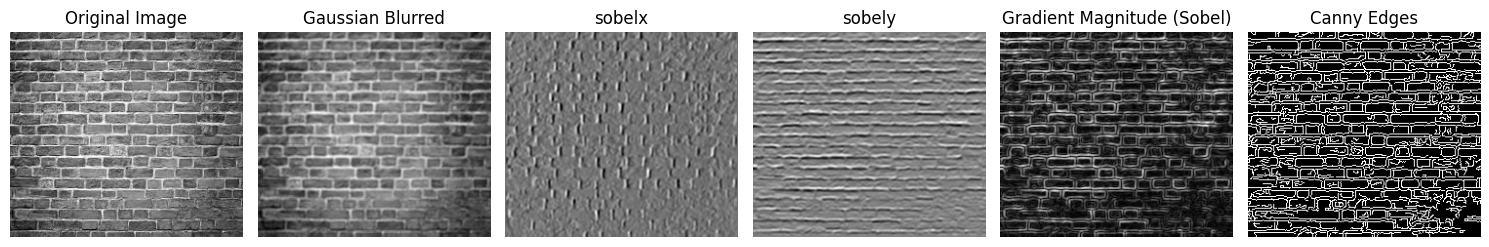

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_diff(**images):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    axs = axs.flatten() if n > 1 else [axs]
    for ax, img_info in zip(axs, images.values()):
        img, title, xlabel, ylabel = img_info
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def canny_edge_detection_steps(image_path):
    # 读取原始图像
    img = cv2.imread(image_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. 高斯滤波
    blurred_img = cv2.GaussianBlur(gray_img, (3, 3), 1.4)
    
    # 2. Sobel运算 - 计算梯度幅度
    sobelx = cv2.Sobel(blurred_img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred_img, cv2.CV_64F, 0, 1, ksize=3)
    sobel_grad = np.sqrt(sobelx**2 + sobely**2)
    
    # 3 & 4. 使用cv2.Canny()完成非最大值抑制和双阈值步骤
    edges = cv2.Canny(blurred_img, 50, 150)
    
    # 展示差异
    show_diff(
        Original=(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), "Original Image", "", ""),
        Blurred=(blurred_img, "Gaussian Blurred", "", ""),
        sobel_x=(sobelx,"sobelx","",""),
        sobel_y=(sobely,"sobely","",""),
        Gradient=(sobel_grad, "Gradient Magnitude (Sobel)", "", ""),
        Edges=(edges, "Canny Edges", "", "")
    )

# 替换为你的图像路径
image_path = './input/brick.jpg'
canny_edge_detection_steps(image_path)


##### Canny Edge Detetion By 手刻法

1. Sobel GX GY G theta 計算 

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
def show_diff(**images):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    axs = axs.flatten() if n > 1 else [axs]
    for ax, img_info in zip(axs, images.values()):
        img, title, xlabel, ylabel = img_info
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
def show_img(img,title,xlabel,ylabel):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
# def filter(img,kernel,kernel_size):
#     r = kernel_size //2 # 圖片半徑 r=2 
#     # print(img)
#     height,width = img.shape[0:2]
#     # 填充 
#     padding_img = np.pad(img,(r,r)) 
#     # print(padding_img)
#     new_img = np.zeros_like(img)
#     for y in range(r,height+r):
#         for x in range(r,width+r):
#             region = padding_img[(y-r):(y+r+1),(x-r):(x+r+1)]# y ,x = 2-2,2+2+1
#             conv = np.sum(np.multiply(region,kernel))
#             conv = np.clip(conv,0,255)
#             new_img[y-r,x-r] = conv
#     return new_img

def filter(img, kernel):
    kernel_size = kernel.shape[0]
    r = kernel_size // 2
    height, width = img.shape[:2]
    padding_img = np.pad(img, ((r, r), (r, r)), 'reflect')
    new_img = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            region = padding_img[y:y+kernel_size, x:x+kernel_size]
            conv = np.sum(np.multiply(region, kernel))
            new_img[y, x] = conv
    return new_img

# test_img = cv2.imread("./input/lotus.jpg")
# show_diff(
#     Image1=(test_img, 'Image 1', 'X Label 1', 'Y Label 1'),
#     Image2=(test_img, 'Image 2', 'X Label 2', 'Y Label 2')
# )

In [8]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint 

def show_diff(**images):
    n = len(images)
    fig, axs = plt.subplots(1, n, figsize=(15, 4))
    axs = axs.flatten() if n > 1 else [axs]
    for ax, img_info in zip(axs, images.values()):
        img, title, xlabel, ylabel = img_info
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
def filter(img, kernel):
    kernel_size = kernel.shape[0]
    r = kernel_size // 2
    height, width = img.shape[:2]
    padding_img = np.pad(img, ((r, r), (r, r)), 'reflect')
    new_img = np.zeros_like(img).astype(np.float32)
    for y in range(height):
        for x in range(width):
            region = padding_img[y:y+kernel_size, x:x+kernel_size]
            conv = np.sum(np.multiply(region, kernel))
            if conv <= 0 :
                conv = 0 
            new_img[y, x] = conv
    return new_img
def get_guass_kernel(kernel_size, sigma):
    r = int(kernel_size//2)
    kernel = np.zeros((kernel_size, kernel_size))
    for y in range(0-r,0+r+1):
        for x in range(0-r,0+r+1):
            kernel[y+1,x+1] = 1/(2*np.pi*(sigma**2))*np.exp(-(x**2+y**2)/(2*(sigma**2)))
    # normalize 
    sum_of_kernel = np.sum(kernel)
    kernel = kernel / sum_of_kernel
    return kernel
# 輸入圖片
img = cv2.imread("./input/lotus.jpg")
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray_img = filter(gray_img,get_guass_kernel(kernel_size=3,sigma=1.4))
sobel_GX = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])
sobel_GY = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])
Gx_img = filter(gray_img,sobel_GX) # 有正有負的矩陣 表示的是(x,y)該點的亮度變化(x,y右邊亮=>正值 ,反之則為負)
Gy_img = filter(gray_img,sobel_GY)
# 顯示GX GY G處理後的圖片
# Gx_img = cv2.filter2D(gray_img,-1,sobel_GX) # 有正有負的矩陣 表示的是(x,y)該點的亮度變化(x,y右邊亮=>正值 ,反之則為負)
# Gy_img = cv2.filter2D(gray_img,-1,sobel_GY)
G_img = np.sqrt(Gx_img**2 + Gy_img**2)
pprint(f"GX:{Gx_img}")
pprint(f"Gx_cv:{cv2.filter2D(gray_img,-1,sobel_GX)}")
# print(f"Gy:{Gy_img}")
# print(f"G:{G_img}")
# print(""Gy_img)
# print(G_img)
# G_img_normalized = (G_img - np.min(G_img)) / (np.max(G_img) - np.min(G_img)) * 255 #正規化
G_img *= 255.0 / (G_img.max()-G_img.min())

theta = np.arctan2(Gy_img,Gx_img) * 180 / np.pi #梯度計算 梯度的大小是該方向角度的變化程度
theta[theta < 0] += 180 # 對於那些小於0的角度+180度

# Gx_img = 255-Gx_img
cv2.imshow("gray",gray_img)
cv2.destroyAllWindows()
# show_diff(
#     Origin = (gray_img,"gray_img","width","height"),
#     Image1 = (255-Gx_img,"Gx_img","width","height",),
#     Image2 = (255-Gy_img,"Gy_img","width","height",),
#     Image3 = (G_img,"G_img","width","height",),
#     Image4 = (theta,"theta","width","height",)
# )

# show_diff(
#     Origin = (gray_img,"gray_img","width","height"),
#     Image1 = (cv2.filter2D(gray_img,-1,sobel_GX),"Gx_img_cv","width","height",),
#     Image2 = (cv2.filter2D(gray_img,-1,sobel_GY),"Gy_img_cv","width","height",),
#     # Image3 = (,"G_img_cv","width","height",),
#     # Image4 = (theta,"theta_cv","width","height",)
# )

('GX:[[ 0.        24.660316  37.375465  ...  0.         0.         0.       ]\n'
 ' [ 0.        18.176044  29.102444  ...  0.         0.         0.       ]\n'
 ' [ 0.         2.9774933  9.6037445 ...  0.         0.         0.       ]\n'
 ' ...\n'
 ' [ 0.         0.         0.        ...  2.7226524  3.4187584  0.       ]\n'
 ' [ 0.         0.         0.        ...  0.         1.0265541  0.       ]\n'
 ' [ 0.         0.         0.        ...  0.         0.         0.       ]]')
('Gx_cv:[[  0.          24.660316    37.37547    ... -20.607224   -20.689163\n'
 '    0.        ]\n'
 ' [  0.          18.17604     29.102444   ... -16.911682   -17.501282\n'
 '    0.        ]\n'
 ' [  0.           2.9774933    9.603748   ...  -9.4314575  -11.2634735\n'
 '    0.        ]\n'
 ' ...\n'
 ' [  0.         -11.473862    -0.18441772 ...   2.7226524    3.4187584\n'
 '    0.        ]\n'
 ' [  0.         -15.462006    -4.8767853  ...  -1.4539719    1.0265541\n'
 '    0.        ]\n'
 ' [  0.         -16.1812

2. 非最大值抑制
梯度方向量化到四个主要方向之一（通常是0°, 45°, 90°, 和135°），這樣做是為了簡化後續的邊緣追蹤過程。
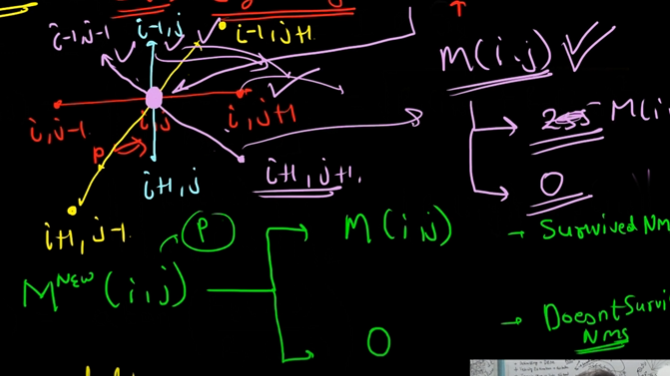

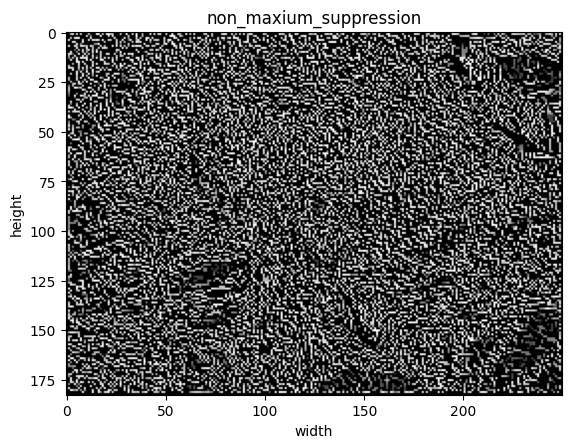

In [8]:
import numpy as np
def non_maximum_suppression(G, angle):
    M, N = G.shape
    Z = np.zeros_like(G)
    for y in range(1,M-1): 
        for x in range(1,N-1):
            try:
                q = 255
                r = 255
                # 取得theta 對應方向的鄰居數值大小
                if (0<=angle[y,x]<22.5) or (157.5<=angle[y,x]<=180):
                    q = G[y,x-1]
                    r = G[y,x+1]
                elif (22.5<=angle[y,x]<67.5): 
                    q = G[y-1,x+1]
                    r = G[y+1,x-1]
                elif (67.5<=angle[y,x]<112.5): 
                    q = G[y-1,x]
                    r = G[y+1,x]
                elif (112.5<=angle[y,x]<157.5): 
                    q = G[y-1,x-1]
                    r = G[y+1,x+1]

                # 比較 如果當前點比鄰居大 這個點設為有數值(代表是邊緣)
                if (G[y,x]>=q) and (G[y,x]>=r):
                    Z[y,x] = G[y,x]
                else:# 否則數值為0
                    Z[y,x] = 0

            except IndexError as e:
                pass
    return Z
# print(theta)
non_maxium_suppression_img = non_maximum_suppression(G_img, theta)
show_img(non_maxium_suppression_img,"non_maxium_suppression","width","height")


4. 雙邊界
* 高於高邊界的訊號 => 強邊緣訊號
* 界於高邊界與低邊界 =>弱邊緣訊號(只有當弱邊緣訊號附近有強邊緣才會把這個點加入強邊緣中)
* 低於低邊界 => 設為0 


[[ 0.     0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.    12.805 ...  0.    15.555  0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]
 ...
 [ 0.     0.    15.81  ...  0.     0.     0.   ]
 [ 0.     0.     0.    ... 12.086  0.     0.   ]
 [ 0.     0.     0.    ...  0.     0.     0.   ]]


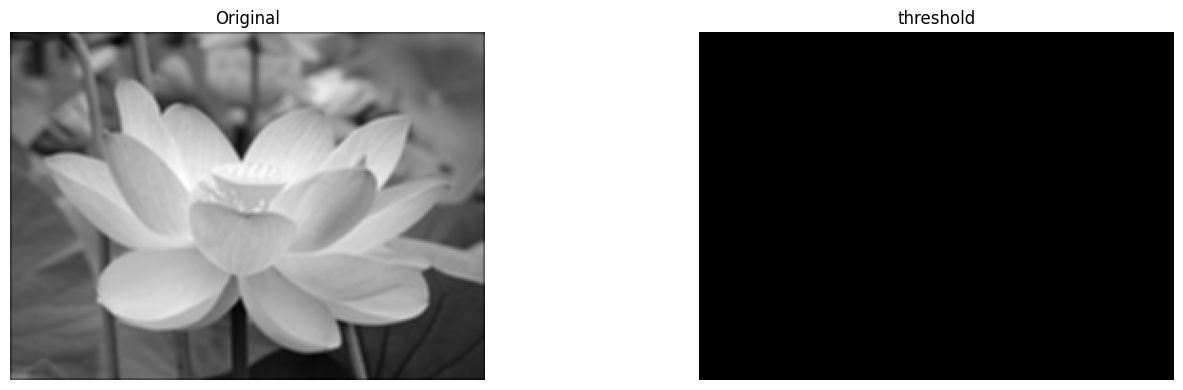

In [9]:
def apply_double_threshold(G, low_threshold, high_threshold):
    M,N=G.shape[0:2]
    strong_edge = np.zeros_like(G)
    weak_edge = np.zeros_like(G)
    strong_edge[G>high_threshold] = 1 
    weak_edge[(G<high_threshold) & (G>=low_threshold)] = 1 

    for y in range(1,M):
        for x in range(1,N):
            if weak_edge[y, x] == 1:
                region = strong_edge[y-1:y+2, x-1:x+2]
                if np.any(region > 0):  # 如果弱边缘附近有强边缘
                    strong_edge[y, x] = 1  # 升级为强边缘
    return strong_edge*255
print(non_maxium_suppression_img)
threshold_img = apply_double_threshold(non_maxium_suppression_img,50,100)
show_diff(
    Image1=(gray_img,"Original","",""),
    Image2=(threshold_img,"threshold","",""),
)


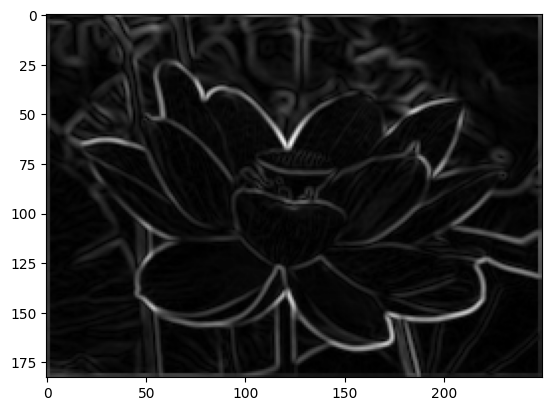

In [10]:
import numpy as np
from scipy.signal import convolve2d

def sobel_edge_detection(image):
    # Sobel kernels for edge detection
    Gx = np.array([[-1, 0, 1],
                [-2, 0, 2],
                [-1, 0, 1]])
    Gy = np.array([[-1, -2, -1],
                [ 0,  0,  0],
                [ 1,  2,  1]])

    # Apply Sobel kernels to the image
    sobel_x = convolve2d(image, Gx, mode='same', boundary='symm')
    sobel_y = convolve2d(image, Gy, mode='same', boundary='symm')

    # Calculate the magnitude of the gradient
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the gradient magnitude to the range 0 to 255
    gradient_magnitude = (gradient_magnitude / gradient_magnitude.max()) * 255

    return gradient_magnitude.astype(np.uint8)

# For demonstration purposes, let's create a simple 5x5 "image"
# with a clear edge in it
test_image = np.array([[100, 100, 100, 100, 100],
                    [100, 100, 100, 100, 100],
                    [  0,   0,   0,   0,   0],
                    [100, 100, 100, 100, 100],
                    [100, 100, 100, 100, 100]], dtype=np.uint8)

# Now let's apply our Sobel edge detection to this test image
sobel_result = sobel_edge_detection(gray_img)
show_img(sobel_result,"","","")